# Modelling Weekend Points for the Aston Martin F1 Team

In this project, I'll be using data from the Aston Martin Aramco Formula One Team's race results since the team's creation in 2021. With this data, I'll attempt to predict how many points the team will score at the next race weekend, based on their past performance.

In [2]:
# Initializes the preliz, arviz, and pymc packages, should they not already be installed on the Jupyter server.

!pip install "preliz[full,notebook]"
!pip install "arviz"
!pip install "pymc"


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for arviz from https://files.pythonhosted.org/packages/86/e8/74277b973ecc46d7c30660de441ca4eb3e9e0cc73b9b5e19e85f02ef4952/arviz-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for xarray>=2022.6.0 from https://files.pythonhosted.org/packages/94/28/3a6365e45721c7c9078968ed94b4a60076bc31d73b8519021a69b4995b63/xarray-2024.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for h5netcdf>=1.0.2 from https://files.pythonhosted.org/packages/73/05/0ad1bb1305de0278457e28069a91c5d03f9e2d014e54ac505abfa56ba3e7/h5netcdf-1.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.1.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Using cached typing_extensions-4.12.2-py3-none

First, I'll import the necessary packages and read the team's data from a CSV on GitHub. Then, I'll set the `pointsData` variable to just the points column. This is what I'll be using to create my models.

In [2]:
"""
UNUSED IMPORTS:

import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
"""
import pandas as pd
import arviz as az
import pymc as pm
rawData = 'https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/constructor_results_FILTERED_ASTON-MARTIN.csv'
pointsData = pd.read_csv(rawData)["points"]
# Print for debugging
pointsData

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


0      0
1      0
2      0
3      0
4      0
      ..
79     0
80    14
81     0
82     0
83    10
Name: points, Length: 84, dtype: int64

For my prior, I used the minimum points they scored in a weekend, 0, to the maximum they've ever scored as a team, 27. This will be our `lower` and `upper` values in our Uniform distribution.

This was the first model I tried, a `normal` distribution, directly from the notes.

In [13]:
#N for normal
with pm.Model() as model_chemshiftN:
    # I have no idea where the mean should be, but its reasonalbe to assume
    # its between our lowest and highest values recorded
    μ = pm.Uniform('μ', lower=0, upper=27)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=5)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=pointsData)
    idata_chemshiftN = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


More plotting from the notes:

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

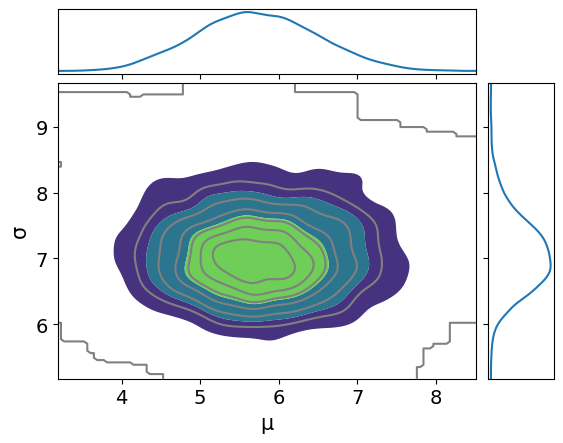

In [14]:
az.plot_pair(idata_chemshiftN, kind='kde', marginals=True)

And here is the graph. As you can probably see, the posterior predictive mean is nowhere near the observed data, meaning this distribution is a pretty bad option for our dataset.

Sampling: [Y]


Output()

<Axes: xlabel='Y'>

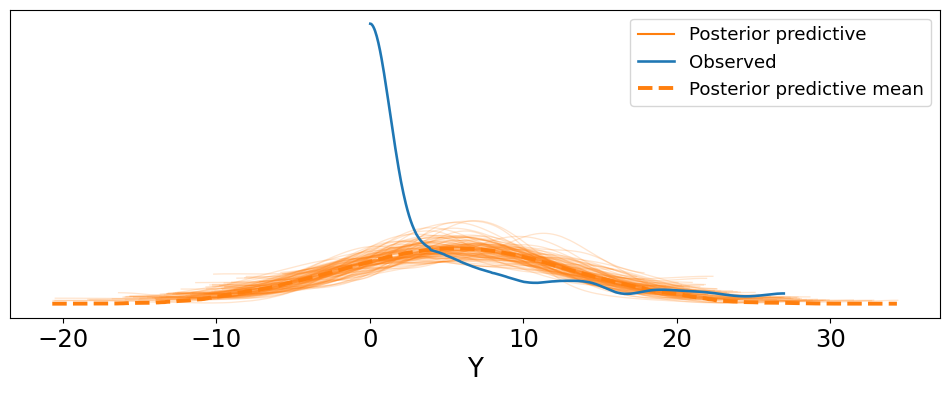

In [15]:
pm.sample_posterior_predictive(idata_chemshiftN, model=model_chemshiftN, extend_inferencedata=True)

az.plot_ppc(idata_chemshiftN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The next distribution I tried was also from the notes, and was the `StudentT` distribution. Here's the same code, but for the `StudentT` distribution:

In [9]:
with pm.Model() as model_chemshiftT:
    # weak prior
    μ = pm.Uniform('μ', lower=0, upper=27)

    #the same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #this is our normality parameter; lam = 1/30 gives a mean of 30
    ν = pm.Exponential('ν', lam = 1/30)

    #new likelihood, same data
    y = pm.StudentT('y', mu=μ, sigma=σ, nu = ν, observed=pointsData)
    idata_chemshiftT = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling the posterior:

In [10]:
pm.sample_posterior_predictive(idata_chemshiftT, model=model_chemshiftT, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

And, here's the plot. Also a pretty bad fit for our observed data, but seems to be a bit closer.

(0.0, 25.0)

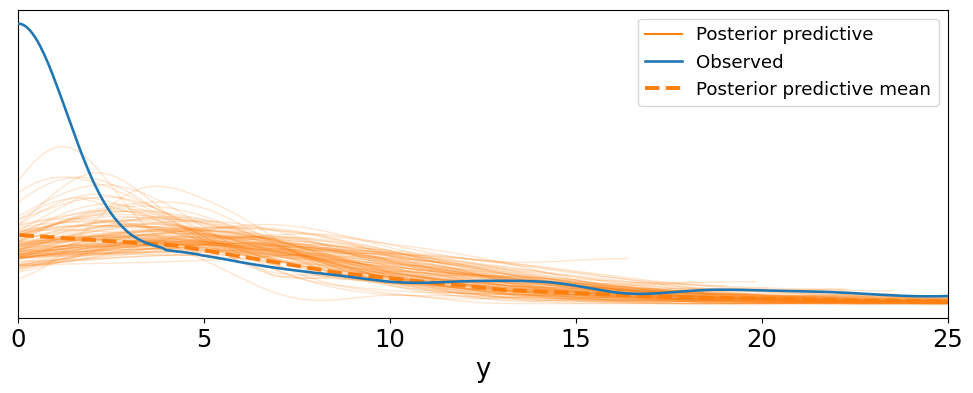

In [11]:
ax = az.plot_ppc(idata_chemshiftT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 25)

The next distribution I tried was the `Exponential` distribution. So, I adapted the code from the notes to use the `Exponential` distribution, as well as combined all of the code into one block below:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Y]


Output()

<Axes: xlabel='Y'>

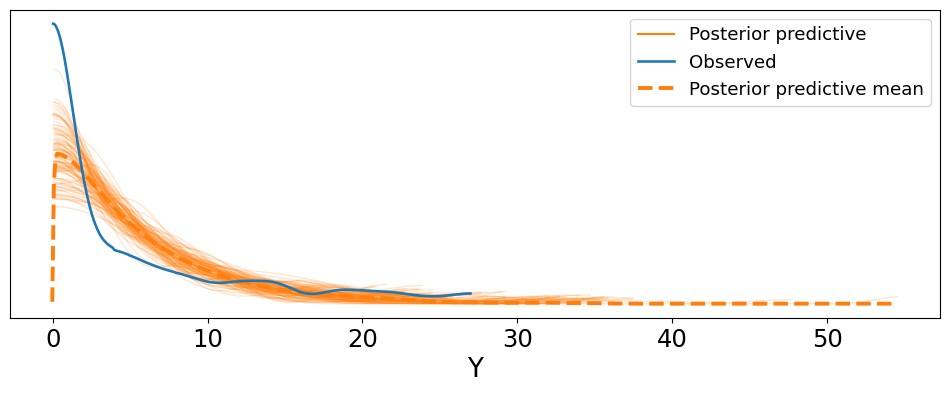

In [25]:
#E for Exponential
with pm.Model() as model_chemshiftE:
    # I have no idea where the mean should be, but its reasonalbe to assume
    # its between our lowest and highest values recorded
    μ = pm.Uniform('μ', lower=0, upper=27)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=5)

    #our fancy new likelihood, with two priors
    Y = pm.Exponential('Y', lam=μ, observed=pointsData)
    idata_chemshiftE = pm.sample()

pm.sample_posterior_predictive(idata_chemshiftE, model=model_chemshiftE, extend_inferencedata=True)

az.plot_ppc(idata_chemshiftE, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

As you can see, the `Exponential` distribution provided the best fit to the observed data. I wasn't able to get other distributions working (courtesy of pymc), but this provided the best option I've seen.

## Conclusion

In the end, the `Exponential` distribution provided the best result. I think that there is probably a better distribution somewhere, but I kept getting weird errors that I didn't understand. Additionally, a larger dataset would likely benefit the posterior, as my dataset is limited by the amount of races that the team has participated in during its relatively short lifetime, for a Formula One team at least.